In [32]:
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
from array import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler


def fetch_data (upto_dates = 240 , tickers='BTC-USD'):
  data = yf.download(tickers=tickers, period = f'{upto_dates}d', interval = '1d')
  new_array = np.array(data.index.to_pydatetime(), dtype=np.datetime64)
  o = data.iloc[: , 0].values
  h = data.iloc[: , 1].values
  l = data.iloc[: , 2].values
  c = data.iloc[: , 3].values
  df= pd.DataFrame(new_array)
  df.columns = ['Date']
  df['Open']=o
  df['High']=h
  df['Low']=l
  df['Close']=c
  return df

You should consider upgrading via the 'C:\Python\python.exe -m pip install --upgrade pip' command.


In [33]:
df=fetch_data(200)
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close
0,2021-03-23,54511.660156,55985.441406,53470.695312,54738.945312
1,2021-03-24,54710.488281,57262.382812,52514.332031,52774.265625
2,2021-03-25,52726.746094,53392.386719,50856.570312,51704.160156
3,2021-03-26,51683.011719,55137.312500,51579.855469,55137.312500
4,2021-03-27,55137.566406,56568.214844,54242.910156,55973.511719
...,...,...,...,...,...
195,2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344
196,2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500
197,2021-10-06,51486.664062,55568.464844,50488.191406,55361.449219
198,2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375


In [34]:

cols =['Open']

In [35]:
df_for_training = df[cols].astype(float)
print(df_for_training.shape)
df_for_training.head(7)

(200, 1)


,Open
0,54511.660156
1,54710.488281
2,52726.746094
3,51683.011719
4,55137.566406
5,55974.941406
6,55947.898438


In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [84]:
trainX = []
trainY = []
n_past = 10
for i in range(n_past, len(df_for_training_scaled)):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i , 0])   # predict only open for next day

trainX = np.array(trainX)
trainY = np.array(trainY)
print('shape of trainx is :',trainX)
print('shape of trainy is :',trainY)

shape of trainx is : [[[0.73279662]
  [0.73869176]
  [0.67987494]
  ...
  [0.82881546]
  [0.86380607]
  [0.86369593]]

 [[0.73869176]
  [0.67987494]
  [0.64892882]
  ...
  [0.86380607]
  [0.86369593]
  [0.86880501]]

 [[0.67987494]
  [0.64892882]
  [0.75135438]
  ...
  [0.86369593]
  [0.86880501]
  [0.87765629]]

 ...

 [[0.38322899]
  [0.39842594]
  [0.36778963]
  ...
  [0.53024264]
  [0.5459236 ]
  [0.57456656]]

 [[0.39842594]
  [0.36778963]
  [0.33411043]
  ...
  [0.5459236 ]
  [0.57456656]
  [0.64310723]]

 [[0.36778963]
  [0.33411043]
  [0.34852851]
  ...
  [0.57456656]
  [0.64310723]
  [0.75731565]]]
shape of trainy is : [0.86880501 0.87765629 0.82450761 0.85878339 0.87097104 0.84175373
 0.77988743 0.84590627 0.84374823 0.89096355 0.90073941 0.89226187
 1.         0.9867005  0.99213549 0.94088403 0.91633327 0.78260545
 0.76749038 0.79089374 0.71338945 0.65061282 0.6329245  0.60059493
 0.57168559 0.7185247  0.74836187 0.74306806 0.70483733 0.82776384
 0.83106083 0.79531578 0.8129

In [85]:
print(trainX.shape)
print(trainY.shape)

(190, 10, 1)
(190,)


In [92]:
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(32))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 10, 256)           264192    
_________________________________________________________________
lstm_21 (LSTM)               (None, 10, 128)           197120    
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 64)            49408     
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [87]:
history = model.fit(trainX, trainY, epochs=100,  validation_split=0.1, verbose=1)

Epoch 1/100
6/6 [==============================] - 5s 212ms/step - loss: 0.1754 - val_loss: 0.0270
Epoch 2/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0390 - val_loss: 0.0294
Epoch 3/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0302 - val_loss: 0.0211
Epoch 4/100
6/6 [==============================] - 0s 38ms/step - loss: 0.0241 - val_loss: 0.0237
Epoch 5/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0236 - val_loss: 0.0242
Epoch 6/100
6/6 [==============================] - 0s 38ms/step - loss: 0.0185 - val_loss: 0.0254
Epoch 7/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0217 - val_loss: 0.0289
Epoch 8/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0202 - val_loss: 0.0268
Epoch 9/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0174 - val_loss: 0.0258
Epoch 10/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0171 - val_loss: 0.0244
Epoch 11/100
6/6 [

Epoch 84/100
6/6 [==============================] - 0s 46ms/step - loss: 0.0072 - val_loss: 0.0115
Epoch 85/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0073 - val_loss: 0.0118
Epoch 86/100
6/6 [==============================] - 0s 47ms/step - loss: 0.0087 - val_loss: 0.0169
Epoch 87/100
6/6 [==============================] - 0s 56ms/step - loss: 0.0080 - val_loss: 0.0122
Epoch 88/100
6/6 [==============================] - 0s 52ms/step - loss: 0.0078 - val_loss: 0.0146
Epoch 89/100
6/6 [==============================] - 0s 49ms/step - loss: 0.0064 - val_loss: 0.0107
Epoch 90/100
6/6 [==============================] - 0s 47ms/step - loss: 0.0049 - val_loss: 0.0114
Epoch 91/100
6/6 [==============================] - 0s 55ms/step - loss: 0.0068 - val_loss: 0.0107
Epoch 92/100
6/6 [==============================] - 0s 50ms/step - loss: 0.0062 - val_loss: 0.0114
Epoch 93/100
6/6 [==============================] - 0s 51ms/step - loss: 0.0070 - val_loss: 0.0103
Epoch 94/1

In [82]:
# Yash's attempt at graph

last_index = len(df['Open'])
new_df = df['Open'][last_index-20:]

print(new_df[last_index-20:last_index-10])




Series([], Name: Open, dtype: float64)


In [46]:
df

,Date,Open,High,Low,Close
0,2021-03-23,54511.660156,55985.441406,53470.695312,54738.945312
1,2021-03-24,54710.488281,57262.382812,52514.332031,52774.265625
2,2021-03-25,52726.746094,53392.386719,50856.570312,51704.160156
3,2021-03-26,51683.011719,55137.312500,51579.855469,55137.312500
4,2021-03-27,55137.566406,56568.214844,54242.910156,55973.511719
...,...,...,...,...,...
195,2021-10-04,48208.906250,49456.777344,47045.003906,49112.902344
196,2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500
197,2021-10-06,51486.664062,55568.464844,50488.191406,55361.449219
198,2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375


[*********************100%***********************]  1 of 1 completed
out_len : 0


C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


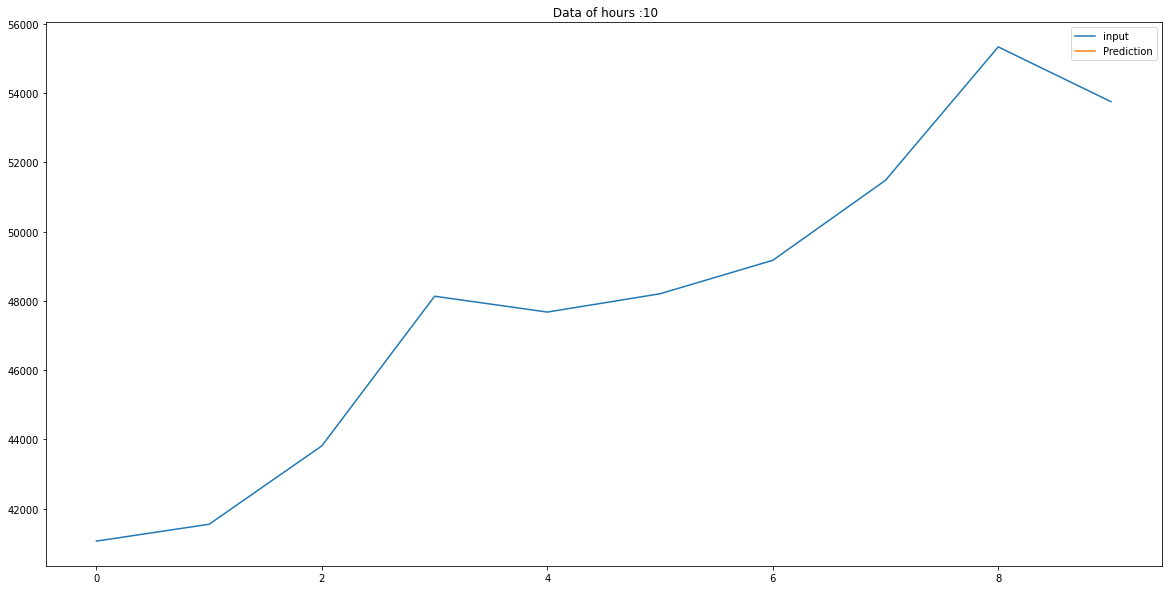

In [90]:
df=fetch_data(10)
data =df['Open']
data = np.array(data)
data1= data[:10]

input_data =data1
data_scaled = data1.reshape((n_past,1))
data_scaled = scaler.transform(data_scaled).tolist()
out_data = []
i=0
ran = len(data)-10

while(i<ran):
  x_input=data_scaled[len(data_scaled)-n_past:]
  # print(f" for input : {x_input}")
  x_input=np.array(x_input).reshape((1,n_past,1))
  y_pred = model.predict(x_input)[0][0]
  # print(f" Output is : {y_pred}")
  
  out_data.append(scaler.inverse_transform([y_pred])[0])
  data_scaled.append([y_pred])
  i=i+1
print("out_len :",len(out_data))
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(data)),data, label='input')
plt.plot(np.arange(10,len(data)),out_data ,label='Prediction')
plt.title(f" Data of hours :{len(data)}")
plt.legend()

In [ ]:
# df=fetch_data(10)
# data =df['Open']
# data = np.array(data)
# data1= data[len(data)-n_past:]

# input_data =data1
# data_scaled = data1.reshape((n_past,1))
# data_scaled = scaler.transform(data_scaled).tolist()
# out_data = []
# i=0

# while(i<10):
#   x_input=data_scaled[len(data_scaled)-n_past:]
#   print(f" for input : {x_input}")
#   x_input=np.array(x_input).reshape((1,n_past,1))
#   y_pred = model.predict(x_input)[0][0]
#   print(f" Output is : {y_pred}")
  
#   out_data.append(scaler.inverse_transform([y_pred])[0])
#   data_scaled.append([y_pred])
#   i=i+1
# plt.figure(figsize=(20,10))
# plt.plot(np.arange(0,len(data)),data, label='input')
# plt.plot(np.arange(len(data),len(data)+i),out_data ,label='Prediction')
# plt.title(f" Data of hours :{len(data)}")
# plt.legend()

In [220]:
len(data)

233